In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
from aacgmv2 import convert_mlt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from davitpy import utils
%matplotlib inline

In [2]:
eventDate = datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,5,16,8,0)
selDate = datetime.datetime(2011,5,16,8,20)
timeEnd = datetime.datetime(2011,5,16,9,0)
azimCutoff = 30.
plotMlatRange = [ 55., 70. ]
velScale = [ 0., 250. ]
saisVelCutoff = 50.
# Plotting SAPS vels arrows
arrowLenFactor = 8
coords = "mlt"

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

In [4]:
ampSCWDF = feather.read_dataframe('../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')

In [5]:
# read from the feather file
fitsDF = feather.read_dataframe('../data/lshell-fits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
# set a few filters to the data
# 1) azim should be -90+/-cutoff
# fitsDF = fitsDF[ numpy.abs( fitsDF["azimSAPS"] ) < azimCutoff ]
# Calculate details for plotting arrows
# We plot the arrows on the time axis, so instead of normMLT
# we'll use time to estimate the end points of the vectors!
fitsDF["time"] = fitsDF["date"].map(lambda x:(x.hour + x.minute/60.)*arrowLenFactor)
# Need three MLATs (min, med and max) if you we want to plot
# the latitudinal extent of the flows!
fitsDF["endPtMedMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["medLat"], 2)
fitsDF["endPtMinMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["minLat"], 2)
fitsDF["endPtMaxMLAT"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) * numpy.cos( \
            numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) ) +\
             fitsDF["maxLat"], 2)
# We can have just one MLT
fitsDF["endPtTime"] = numpy.round( (\
            fitsDF["velSAPS"]/1000.) *\
             numpy.sin( numpy.deg2rad(-90-1*fitsDF["azimSAPS"]) )\
              + fitsDF["time"], 2)
fitsDF.head()

,azimSAPS,azimSTD,date,maxLat,maxMLT,medLat,medMLT,minLat,minMLT,velSAPS,velSTD,time,endPtMedMLAT,endPtMinMLAT,endPtMaxMLAT,endPtTime
0,20.427979,3.131936,2011-05-16 08:02:00,59.1016,-0.5264,57.59150,-1.65780,56.1310,-2.3693,140.303240,12.444799,64.266667,57.54,56.08,59.05,64.14
1,20.029809,3.104352,2011-05-16 08:04:00,59.1999,-0.5324,57.77460,-1.62230,56.1979,-2.3361,146.497726,13.082398,64.533333,57.72,56.15,59.15,64.40
2,19.922040,2.151380,2011-05-16 08:06:00,59.6040,-0.4981,57.94995,-1.58405,56.1979,-1.8762,167.429700,9.992434,64.800000,57.89,56.14,59.55,64.64
3,19.473456,1.896487,2011-05-16 08:08:00,59.9090,-0.4070,58.10670,-1.56180,56.1979,-1.9634,181.309917,9.356487,65.066667,58.05,56.14,59.85,64.90
4,18.779410,1.783143,2011-05-16 08:10:00,59.9090,-0.4308,58.30370,-1.53230,56.1296,-1.9353,198.198167,9.559932,65.333333,58.24,56.07,59.85,65.15


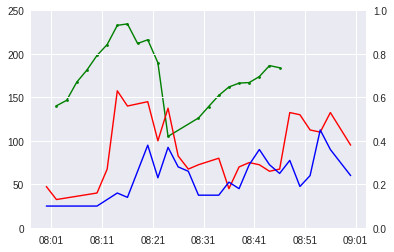

In [6]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax2 = ax.twinx()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'g' )
ax.plot( fitsDF["date"].values, fitsDF["velSAPS"].values, 'g.' )
ax2.plot( ampSCWDF['scwLocDates'].values, ampSCWDF['scwJrUp'].values, 'r' )
ax2.plot( ampSCWDF['scwLocDates'].values, numpy.abs(ampSCWDF['scwJrDown'].values), 'b' )
# ax2.axis('off')
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


# ax.set_ylim([0,250])
ax.set_yticks( numpy.arange(0,300,50) )
# ax2.set_ylim([0,1.5])
ax2.set_yticks( numpy.arange(0,1.2,0.2) )

fig1.savefig("../plots/vels-amp-ts.pdf",bbox_inches='tight')

In [7]:
# Read AMPERE data
ampFName = "../data/" + eventDate.strftime("%Y%m%d") + ".0000.86400.120.north.grd.ncdf"
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-05-16,2011-05-16 00:10:00,89.0,0.0,82.529999,60.080002,76.720001,67.349998,-2.50,-0.21
1,2011-05-16,2011-05-16 00:10:00,88.0,0.0,80.660004,31.370001,76.199997,41.020000,-2.55,-0.27
2,2011-05-16,2011-05-16 00:10:00,87.0,0.0,61.980000,1.050000,61.169998,10.080000,4.62,-0.28
3,2011-05-16,2011-05-16 00:10:00,86.0,0.0,32.880001,-19.570000,35.610001,-13.990000,13.99,-0.25
4,2011-05-16,2011-05-16 00:10:00,85.0,0.0,9.180000,-25.520000,13.440000,-23.559999,22.02,-0.18


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


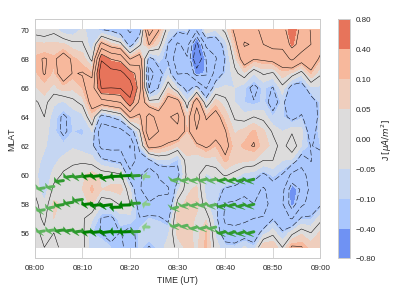

In [8]:
# Some temp constants
plotMltChsn = 22
plotJrCutoff = 0.
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=10)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= timeStart) & (ampDF["start_date"] <= timeEnd) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)
ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data
velColors = [ "#feebe2", "#fbb4b9", "#f768a1", "#c51b8a", "#7a0177" ]
# ax.scatter( fitsDF["date"].values, fitsDF["medLat"].values,\
#            c=fitsDF["velSAPS"].values, s=fitsDF["velSAPS"].values/3.,\
#           cmap=ListedColormap(sns.light_palette("Purple")), alpha=0.75)

ax.set_xlim( [timeStart, timeEnd] )
ax.set_ylim( plotMlatRange )

ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
seaMap = ListedColormap( sns.light_palette("green") )
ax2 = ax.twiny()
for index, row in fitsDF.iterrows():
    currCol = seaMap( colNorm(row['velSAPS']) )
    if row['velSAPS'] < saisVelCutoff:
        currCol = "#636363"
    # Min Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["minLat"],\
                row['endPtMinMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["minLat"], row["endPtTime"]-row["time"], row['endPtMinMLAT']-row["minLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Median Lat Loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["medLat"],\
                row['endPtMedMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["medLat"], row["endPtTime"]-row["time"], row['endPtMedMLAT']-row["medLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
    # Max Lat loc
    ax2.plot( [ row["time"], row["endPtTime"]], [ row["maxLat"],\
                row['endPtMaxMLAT'] ], color=currCol, linewidth=3.0 )        
    ax2.arrow( row["time"], row["maxLat"], row["endPtTime"]-row["time"], row['endPtMaxMLAT']-row["maxLat"],\
             head_width=0.6, head_length=0.1, fc=currCol, ec=currCol)
# Need to carefully set the x-axis
ax2.set_xlim([(timeStart.hour + timeStart.minute/60.)*arrowLenFactor,\
              (timeEnd.hour + timeEnd.minute/60.)*arrowLenFactor])
ax2.axis('off')

fig.savefig( "../plots/sapsSCW.pdf",bbox_inches='tight' )

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


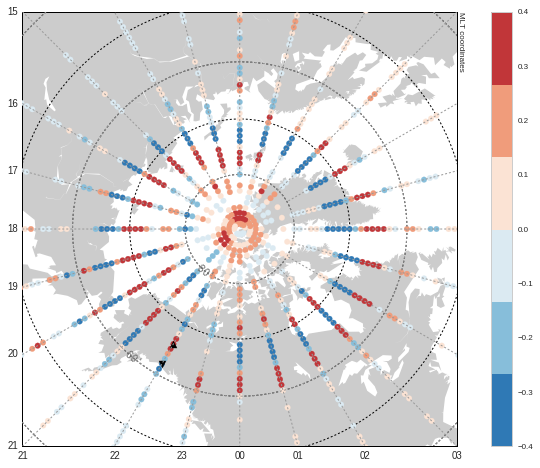

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)

seaMap = ListedColormap(sns.color_palette("RdBu_r"))

plotAmpDF = ampDF[ (ampDF["start_date"] == selDate) &\
                 (numpy.abs(ampDF["Jr"]) >= 0.05) ]

# plotAmpDF = plotAmpDF[ ["mlt", "mlat",\
#                         "Jr"] ].pivot( "mlt", "mlat" )
# mltVals = plotAmpDF.index.values*15.
# mlatVals = plotAmpDF.columns.levels[1].values
# mltCntr, mlatCntr  = numpy.meshgrid( mltVals, mlatVals )



mapHandle = utils.plotUtils.mapObj(boundinglat=50., coords=coords, lat_0=90., lon_0=0, datetime=selDate)
parallels = numpy.arange(0.,81,10.)
mapHandle.drawparallels(parallels)
# xVecs, yVecs = mapHandle(mltCntr, mlatCntr, coords=coords)
xVecs, yVecs = mapHandle(plotAmpDF["mlt"].values*15., plotAmpDF["mlat"].values, coords=coords)
ampPlot = mapHandle.scatter( xVecs, yVecs, c=plotAmpDF["Jr"].values, zorder=7., cmap=seaMap, ax=ax, vmin=-0.4,vmax=0.4 )
# ampPlot = mapHandle.contourf( xVecs, yVecs, plotAmpDF["Jr"].values.T, zorder=7., cmap=seaMap, ax=ax, vmin=-0.4,vmax=0.4 )

##### PLOT SCW ####
##### PLOT SCW ####
scwDwnMlat = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwLocMlatDown"].values
scwDwnMLT = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwMLTDown"].values
scwUpMlat = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwLocMlatUp"].values
scwUpMLT = ampSCWDF[ ampSCWDF["scwLocDates"] == selDate ]["scwMLTUp"].values

xVecDwn, yVecDwn = mapHandle(scwDwnMLT*15., scwDwnMlat, coords=coords)
xVecUp, yVecUp = mapHandle(scwUpMLT*15., scwUpMlat, coords=coords)

mapHandle.scatter( xVecDwn, yVecDwn, marker='v', s=50, c='k', ax=ax, zorder=8 )
mapHandle.scatter( xVecUp, yVecUp, marker='^', s=50, c='k',ax=ax, zorder=8 )

##### PLOT SCW ####
##### PLOT SCW ####

cbar = plt.colorbar(ampPlot, orientation='vertical')